In [1]:
import  os
import  pandas as pd
from    tqdm import tqdm
import  numpy as np
from    multiprocessing import get_context as context
from    matplotlib import pyplot as plt
%matplotlib inline

# Read the files

# Parameters


header      = ['EventID','TrackID','Particle','EnergyDeposited','XPosition','YPosition','ZPosition','LocalTime','Volume', 'Initial Energy', 'Origin Volume', 'MigrantID']
PROCESSES   = os.cpu_count()-1
Pool        = context("fork").Pool

# Find the files
foldername  = f'../build1/output'
os.system(f'rm -rf ../build1/output/.ipynb_checkpoints')
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def parallel(function):
    def inner(input_array):
        # Parallelize excecution them
        with Pool(PROCESSES) as pool:
            output = list(tqdm(pool.imap(function, input_array),total=len(input_array)))
        return output 
    return inner

# Function to load a single file
def loadfile(filename):
    df = pd.read_csv(os.path.join(foldername,filename),skiprows=16,names=header)
    df.insert(0, 'Filename', filename)
    return df

Found 1024 data files in ../build1/output


# Heat propagation check for build1

In [5]:
mm = 1
cm = 10
micron = 10**(-3)
nm = 10**(-6)

cryostatBottom = -698.771 * mm


copperThickness = 3 * mm
separation      = 2 * mm
copperBoxX      = 2.5 * cm
copperBoxY      = 2.5 * cm
copperBoxPosX   = 0 * cm
copperBoxPosY   = cryostatBottom + copperBoxY/2 + 11.5 * cm + copperThickness
copperBoxPosZ   = 0 * cm

stackX    = 0.5*mm + 150*2*nm + 500*2*nm
stackPosX = copperBoxPosX - copperBoxX/2 + copperThickness + separation + stackX/2
stackPosY = copperBoxPosY
stackPosZ = copperBoxPosZ

tesPosX   = stackX / 2 + 1 * micron / 2
tesPosY   = 0
tesPosZ   = 0

tesVolume = 20*20*1*micron**3

substratePosition = np.array([stackPosX, stackPosY, stackPosZ])
tesPosition       = np.array([tesPosX, tesPosY, tesPosZ])
tesPosition       = tesPosition + substratePosition
tesArea = 20 * 20 * micron**2

In [2]:
def processFile(filename):
    """Filtering out tes hits according to"""

    # loading tes separately because of some error when using a copy
    # using A cos(a) / (4*pi*r^2) approach to calculate the energy that reaches tes 
    tes = loadfile(filename)
    tes = tes[tes.Volume.str.contains('Silicon')] # select only substrate volumes 
    # tes['Distance'] = np.sqrt((tes.XPosition - tesPosition[0])**2 + (tes.YPosition - tesPosition[1])**2 + (tes.ZPosition - tesPosition[2])**2) # distance from a edep to tes
    # tes['EnergyReached'] = tes.EnergyDeposited * tesArea * abs(tes.YPosition - tesPosition[1]) / (4 * np.pi * tes.Distance**3) # energy reached duh
    # tes = tes.groupby('EventID')['EnergyReached'].sum().reset_index() # summing it per event
    tes = tes.groupby('EventID')['EnergyDeposited'].sum().reset_index()
    # tes = tes[tes.EnergyReached > 1*10**(-6)] # filtering out according to tes threshold
    tes = tes[tes.EnergyDeposited > 1*10**(-6)]
    
    # loading the rest of the dataframe
    data = loadfile(filename)
    data['hit'] = (data.EventID.isin(tes.EventID)).astype(int) # we assign event row a hit of 1 if it was registered by the tes above 
    data = data.groupby(['EventID', 'Volume', 'hit'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly
    data = data[~(data.Volume.str.contains('Silicon')) & (data.EnergyDeposited > 0.2)] # removing substrate volumes and apply the sabers threshold
    data = data.groupby(['EventID', 'hit'])['Volume'].count().reset_index() # count how many sabers were hit during the event
    data['Triple'] = (data.Volume == 3).astype(int) # triple coincidences
    data['Quadruple'] = ((data.hit == 1) & (data.Volume == 3)).astype(int) # quadruple 

    tesHits = len(tes)
    triple = sum(data.Triple)
    quad = sum(data.Quadruple)

    return (tesHits, triple, quad)

processFiles        = parallel(processFile)
processed           = processFiles(filenames)
processed           = np.array(processed).T

tesHits             = sum(processed[0])
tripleEvents        = sum(processed[1])
quadrupleEvents     = sum(processed[2])

content = f"TES Hits = {tesHits}; Triple Coincidences = {tripleEvents}; Quadruple Coincidences = {quadrupleEvents}"
print(content)

100%|██████████| 1024/1024 [00:11<00:00, 86.69it/s] 

TES Hits = 1322; Triple Coincidences = 4710; Quadruple Coincidences = 13


# Check quadruple coincidences nature

In [23]:
loadfiles = parallel(loadfile)
file = pd.concat(loadfiles(filenames))
file['ID'] = file['Filename'] + file['EventID'].astype(str)
file = file.drop(columns = ['Filename', 'EventID'])
file

100%|██████████| 1024/1024 [00:17<00:00, 59.70it/s]


,TrackID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy,Origin Volume,MigrantID,ID
0,1,gamma,0.000000,-189.9340,-720.771,56.81390,4.757150,phys2,1013.780,worldVolume_PV,-1,TES-run0-rank753_nt_hits.csv30
1,1,gamma,0.000000,-177.1340,-720.771,-32.89380,5.451900,phys1,30799.200,worldVolume_PV,-1,TES-run0-rank753_nt_hits.csv190
2,1,mu+,3.550550,-183.3100,-720.771,43.57090,4.788630,phys2,1692910.000,worldVolume_PV,-1,TES-run0-rank753_nt_hits.csv194
3,1,mu-,1.880590,-15.1444,-715.771,7.98799,4.516320,phys4,2031800.000,worldVolume_PV,-1,TES-run0-rank753_nt_hits.csv685
4,8,gamma,0.000000,28.1256,-720.771,-24.41770,0.130414,phys1,360.727,Cryostat_Aluminum_PV,-1,TES-run0-rank753_nt_hits.csv1362
...,...,...,...,...,...,...,...,...,...,...,...,...
61703,7,e-,0.012012,-94.6684,-708.520,49.94420,0.007980,phys2,788.164,phys2,-1,TES-run0-rank264_nt_hits.csv976388
61704,7,e-,0.016959,-94.6608,-708.531,49.94000,0.008100,phys2,788.164,phys2,-1,TES-run0-rank264_nt_hits.csv976388
61705,7,e-,0.023088,-94.6571,-708.531,49.94540,0.008172,phys2,788.164,phys2,-1,TES-run0-rank264_nt_hits.csv976388
61706,7,e-,0.002254,-94.6571,-708.531,49.94530,0.008175,phys2,788.164,phys2,-1,TES-run0-rank264_nt_hits.csv976388


In [25]:
tes = file
tes = tes[tes.Volume.str.contains('Silicon')] # select only substrate volumes 
tes = tes.groupby(['ID'])['EnergyDeposited'].sum().reset_index()
# tes['ID'] = tes['Filename'] + tes['EventID'].astype(str)
# tes = tes.drop(columns = ['Filename', 'EventID'])
tes = tes[tes.EnergyDeposited > 1*10**(-6)]
tes

,ID,EnergyDeposited
2,TES-run0-rank0_nt_hits.csv786186,0.301752
5,TES-run0-rank1000_nt_hits.csv294064,0.055239
8,TES-run0-rank1000_nt_hits.csv622210,0.140947
12,TES-run0-rank1002_nt_hits.csv612735,1.273239
13,TES-run0-rank1002_nt_hits.csv693666,0.128754
...,...,...
3646,TES-run0-rank998_nt_hits.csv878478,0.115700
3647,TES-run0-rank998_nt_hits.csv900234,0.432950
3651,TES-run0-rank99_nt_hits.csv119027,0.502903
3653,TES-run0-rank99_nt_hits.csv593256,0.194343


In [26]:
# loading the rest of the dataframe
data = file
# data['ID'] = data['Filename'] + data['EventID'].astype(str)
# data = data.drop(columns = ['Filename','EventID'])
data['hit'] = data.ID.isin(tes.ID).astype(int) # we assign event row a hit of 1 if it was registered by the tes above 
data = data.groupby(['ID', 'Volume', 'hit'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly
data = data[~(data.Volume.str.contains('Silicon')) & (data.EnergyDeposited > 0.2)] # removing substrate volumes and apply the sabers threshold
data = data.groupby(['ID', 'hit'])['Volume'].count().reset_index() # count how many sabers were hit during the event
data['Triple'] = (data.Volume == 3).astype(int) # triple coincidences
data['Quadruple'] = ((data.hit == 1) & (data.Volume == 3)).astype(int) # quadruple
data

,ID,hit,Volume,Triple,Quadruple
0,TES-run0-rank0_nt_hits.csv10010,0,1,0,0
1,TES-run0-rank0_nt_hits.csv10047,0,1,0,0
2,TES-run0-rank0_nt_hits.csv100489,0,1,0,0
3,TES-run0-rank0_nt_hits.csv100825,0,1,0,0
4,TES-run0-rank0_nt_hits.csv100832,0,1,0,0
...,...,...,...,...,...
2806610,TES-run0-rank9_nt_hits.csv99338,0,2,0,0
2806611,TES-run0-rank9_nt_hits.csv99485,0,1,0,0
2806612,TES-run0-rank9_nt_hits.csv99539,0,1,0,0
2806613,TES-run0-rank9_nt_hits.csv99547,0,1,0,0


In [27]:
quad = data[data.Quadruple == 1]
quad

,ID,hit,Volume,Triple,Quadruple
144920,TES-run0-rank125_nt_hits.csv814590,1,3,1,1
178607,TES-run0-rank137_nt_hits.csv130008,1,3,1,1
225286,TES-run0-rank152_nt_hits.csv219491,1,3,1,1
280408,TES-run0-rank170_nt_hits.csv191459,1,3,1,1
633296,TES-run0-rank286_nt_hits.csv744774,1,3,1,1
771708,TES-run0-rank331_nt_hits.csv101223,1,3,1,1
828340,TES-run0-rank34_nt_hits.csv731232,1,3,1,1
902029,TES-run0-rank374_nt_hits.csv772755,1,3,1,1
1229382,TES-run0-rank482_nt_hits.csv18527,1,3,1,1
1486722,TES-run0-rank567_nt_hits.csv100763,1,3,1,1


In [28]:
print(len(quad))

13


In [46]:
quadruple = file[file.ID.isin(quad.ID)]
quadruple = quadruple.groupby(['ID', 'TrackID', 'Particle', 'Origin Volume','Volume'])['EnergyDeposited'].sum().reset_index()
quadruple

,ID,TrackID,Particle,Origin Volume,Volume,EnergyDeposited
0,TES-run0-rank125_nt_hits.csv814590,1,mu+,worldVolume_PV,phys4,1.843280
1,TES-run0-rank125_nt_hits.csv814590,1,mu+,worldVolume_PV,physDetectorSiliconNitride1,0.000306
2,TES-run0-rank125_nt_hits.csv814590,1,mu+,worldVolume_PV,physDetectorSiliconNitride2,0.000302
3,TES-run0-rank125_nt_hits.csv814590,1,mu+,worldVolume_PV,physDetectorSiliconOxide1,0.000038
4,TES-run0-rank125_nt_hits.csv814590,1,mu+,worldVolume_PV,physDetectorSiliconOxide2,0.000118
...,...,...,...,...,...,...
686,TES-run0-rank92_nt_hits.csv877733,1413,e-,phys4,phys1,0.848441
687,TES-run0-rank92_nt_hits.csv877733,1413,e-,phys4,phys4,0.171038
688,TES-run0-rank92_nt_hits.csv877733,1414,e-,phys1,phys1,2.546392
689,TES-run0-rank92_nt_hits.csv877733,1415,e-,phys1,phys1,0.137891


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'worldVolume_PV'),
  Text(1, 0, 'logicCopperBox_PV'),
  Text(2, 0, 'Cryostat_Aluminum_PV'),
  Text(3, 0, 'phys1'),
  Text(4, 0, 'physDetectorSiliconSubstrate'),
  Text(5, 0, 'logicCopperPlate_PV'),
  Text(6, 0, 'phys2'),
  Text(7, 0, 'phys4')])

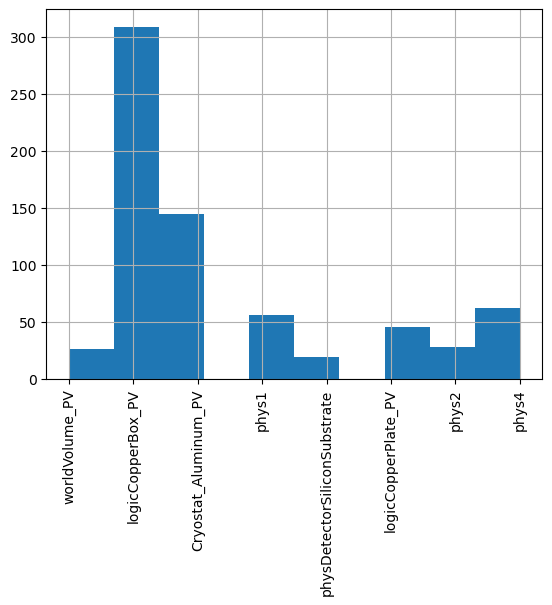

In [39]:
quadruple['Origin Volume'].hist()
plt.xticks(rotation = 90)

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'phys4'),
  Text(1, 0, 'physDetectorSiliconNitride1'),
  Text(2, 0, 'physDetectorSiliconNitride2'),
  Text(3, 0, 'physDetectorSiliconOxide1'),
  Text(4, 0, 'physDetectorSiliconOxide2'),
  Text(5, 0, 'physDetectorSiliconSubstrate'),
  Text(6, 0, 'phys1'),
  Text(7, 0, 'phys2')])

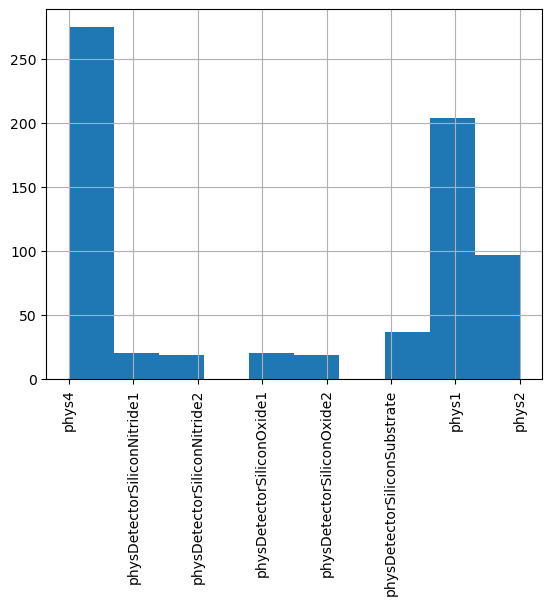

In [40]:
quadruple['Volume'].hist()
plt.xticks(rotation = 90)

In [52]:
quadruple[quadruple.ID == quadruple.ID.unique()[5]]

,ID,TrackID,Particle,Origin Volume,Volume,EnergyDeposited
284,TES-run0-rank331_nt_hits.csv101223,1,e+,worldVolume_PV,phys1,3.739041
285,TES-run0-rank331_nt_hits.csv101223,64,gamma,logicCopperBox_PV,phys2,0.000031
286,TES-run0-rank331_nt_hits.csv101223,67,gamma,logicCopperBox_PV,phys1,0.000000
287,TES-run0-rank331_nt_hits.csv101223,75,gamma,logicCopperBox_PV,phys1,0.000000
288,TES-run0-rank331_nt_hits.csv101223,76,gamma,logicCopperBox_PV,phys1,0.000000
289,TES-run0-rank331_nt_hits.csv101223,82,gamma,logicCopperBox_PV,phys1,0.000018
290,TES-run0-rank331_nt_hits.csv101223,109,gamma,logicCopperBox_PV,phys1,0.000000
291,TES-run0-rank331_nt_hits.csv101223,130,gamma,logicCopperBox_PV,phys4,0.000000
292,TES-run0-rank331_nt_hits.csv101223,177,e-,phys1,phys1,1.037126
293,TES-run0-rank331_nt_hits.csv101223,233,e-,phys2,phys2,0.480813


# Check particle compostion in cosmic run and presence of showers

In [113]:
filename = filenames[0]

tes = loadfile(filename)
tes = tes[tes.Volume.str.contains('Silicon')] # select only substrate volumes 
tes = tes.groupby(['EventID','TrackID'])['EnergyDeposited'].sum().reset_index()
tes = tes[tes.EnergyDeposited > 1*10**(-6)]

data = loadfile(filename)
data['hit'] = (data.EventID.isin(tes.EventID)).astype(int) # we assign event row a hit of 1 if it was registered by the tes above 
data = data.groupby(['EventID','TrackID', 'Volume', 'hit'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly
data = data[~(data.Volume.str.contains('Silicon')) & (data.EnergyDeposited > 0.2)] # removing substrate volumes and apply the sabers threshold
data['Volume'] = data.groupby(['EventID', 'hit'])['Volume'].count().reset_index()['Volume'] # count how many sabers were hit during the event
data['Triple'] = (data.Volume == 3).astype(int) # triple coincidences
data['Quadruple'] = ((data.hit == 1) & (data.Volume == 3)).astype(int) # quadruple
data

,EventID,TrackID,Volume,hit,EnergyDeposited,Triple,Quadruple
0,238,1,1.0,0,3.343540,0,0
4,944,1,2.0,0,3.531930,0,0
5,944,3,1.0,0,0.701684,0,0
6,1034,1,1.0,0,3.859600,0,0
8,1046,1,1.0,0,3.765740,0,0
...,...,...,...,...,...,...,...
2480,242307,1,NaN,0,2.304420,0,0
2482,243091,1,NaN,0,3.279600,0,0
2483,243204,1,NaN,0,2.545200,0,0
2484,243641,1,NaN,0,3.557180,0,0


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'worldVolume_PV'),
  Text(1, 0, 'phys2'),
  Text(2, 0, 'phys4'),
  Text(3, 0, 'Cryostat_Aluminum_PV'),
  Text(4, 0, 'phys1'),
  Text(5, 0, 'logicCopperPlate_PV'),
  Text(6, 0, 'logicCopperBox_PV')])

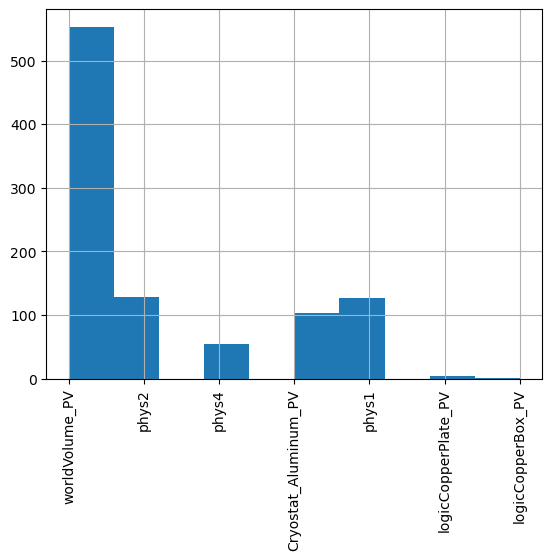

In [114]:
file = loadfile(filenames[0]).fillna('NA')
file = file[~(file.Volume.str.contains('Silicon'))]
# file = file[~(file['Origin Volume'].isin(['phys1', 'phys2', 'phys3']))]
file = file.groupby(['EventID','TrackID','Particle','Origin Volume'])['EnergyDeposited'].sum().reset_index()
file = file[file.EnergyDeposited > 0.2]
file['Origin Volume'].hist()
plt.xticks(rotation = 90)

<Axes: >

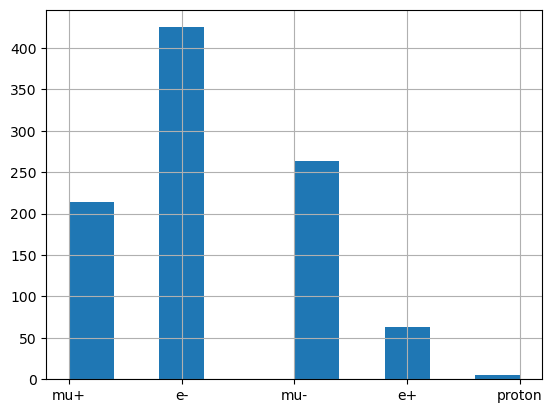

In [115]:
# file[file['Origin Volume'].str.contains('world')]['Particle'].hist()
file['Particle'].hist()

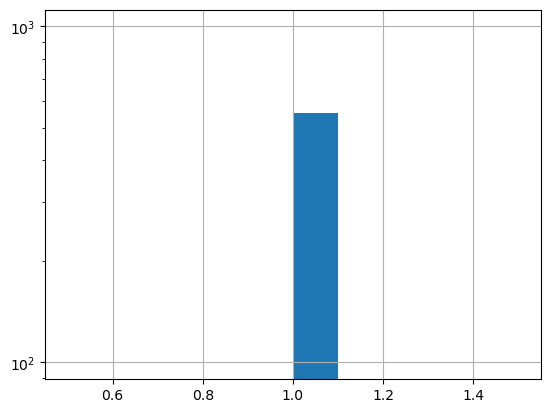

In [116]:
file[file['Origin Volume'].str.contains('world')].groupby(['EventID'])['TrackID'].count().reset_index()['TrackID'].hist()
plt.yscale('log')

# Check for low energy depositions on the TES in cosmic run

100%|██████████| 4096/4096 [00:20<00:00, 203.06it/s]


<Axes: >

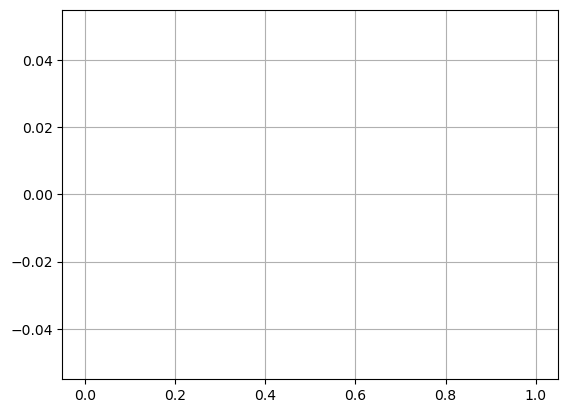

In [112]:
loadfiles = parallel(loadfile)
files = pd.concat(loadfiles(filenames))
tes = files[files.Volume.str.contains('Silicon')]
tes = tes.groupby(['Filename','EventID'])['EnergyDeposited'].sum().reset_index()
tes = tes[(tes.EnergyDeposited > 1 * 10**(-6)) & (tes.EnergyDeposited < 100 * 10**(-6))]
tes.EnergyDeposited.hist(bins = 200)

# Thorium run check

## Double coincidence counting

In [ ]:
def processFile(filename):
    file = loadfile(filename)
    # file = file[file.Particle != 'alpha']
    # file = file[file.EnergyDeposited > 0.0]
    # file = file.groupby(['EventID', 'TrackID','Volume'])['EnergyDeposited'].sum().reset_index()

    tes = file[file.Volume.str.contains('Silicon')]
    tesIn = tes[tes.MigrantID != -1]
    tesIn = tesIn.drop(columns = ['TrackID'])
    tesIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    tesOut = tes[tes.MigrantID == -1]
    tes = pd.concat([tesOut, tesIn])
    tes = tes.drop(columns = 'MigrantID')
    tes = tes.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    tes = tes[tes.EnergyDeposited > 0.0]
    
    saber = file[file.Volume.str.contains('Saber')]
    saberIn = saber[saber.MigrantID != -1]
    saberIn = saberIn.drop(columns = ['TrackID'])
    saberIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    saberOut = saber[saber.MigrantID == -1]
    saber = pd.concat([saberOut, saberIn])
    saber = saber.drop(columns = 'MigrantID')
    saber = saber.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    saber = saber[saber.EnergyDeposited >= 0.2]
    
    # if len(pd.merge(saber,tes, on = ['EventID', 'TrackID'], how = 'inner')) != len(tes):
    #     print(filename)
    

#     double = pd.merge(saber, tes, on = ['EventID', 'TrackID'], how = 'inner')
#     if len(double) > 0:
#         print(double)
    return (len(tes), len(saber), len(double))

processFiles        = parallel(processFile)
processed           = processFiles(filenames)
processed           = np.array(processed).T

tesHits             = sum(processed[0])
saberHits           = sum(processed[1])
triple              = sum(processed[2])

content = f"TES Hits = {tesHits}; saber Hits = {saberHits}; Double Coincidences = {triple}"
print(content)

## Couting alpha secondaries in the saber

In [17]:
def processFile(filename):
    file = loadfile(filename)
    data = file[file.Volume.str.contains('Saber')]
    data = data.groupby(['EventID','TrackID','Particle', 'Origin Volume', 'MigrantID'])['EnergyDeposited'].sum().reset_index()

    originInside = data[data['Origin Volume'].str.contains('Silicon')]
    originInside = originInside.drop(columns = ['TrackID', 'Particle','Origin Volume'])
    originInside = originInside.rename(columns = {'MigrantID':'TrackID', 'EnergyDeposited':'EnergyFromInside'})

    originOutside = data[~(data['Origin Volume'].str.contains('Silicon'))]
    originOutside = originOutside.drop(columns = ['Origin Volume','MigrantID'])
    originOutside = originOutside.rename(columns = {'EnergyDeposited':'EnergyFromOutside'})

    combined = pd.merge(originOutside, originInside, on = ['EventID', 'TrackID'], how = 'left').fillna(0)
    combined['EnergyDeposited'] = combined['EnergyFromOutside'] + combined['EnergyFromInside']
    combined = combined[combined['EnergyDeposited'] > 0.2]
    combined = combined[combined.Particle != 'alpha']
    
    return len(combined)

processFiles        = parallel(processFile)
processed           = processFiles(filenames)
saberHits           = sum(processed)

print(saberHits)

100%|██████████| 1024/1024 [01:02<00:00, 16.34it/s]


1999326


# Weird stuff check

In [ ]:
weirdFiles = ['TES-run0-rank61_nt_hits.csv', 'TES-run0-rank828_nt_hits.csv', 'TES-run0-rank636_nt_hits.csv', 'TES-run0-rank338_nt_hits.csv', 'TES-run0-rank278_nt_hits.csv',
              'TES-run0-rank443_nt_hits.csv', 'TES-run0-rank319_nt_hits.csv', 'TES-run0-rank849_nt_hits.csv', 'TES-run0-rank512_nt_hits.csv']

In [ ]:
loadfiles = parallel(loadfile)

In [ ]:
weirdData = pd.concat(loadfiles(weirdFiles))

In [ ]:
def processFile(filename):
    file = loadfile(filename)
    file = file[file.Particle != 'alpha']
    # file = file[file.EnergyDeposited > 0.0]
    # file = file.groupby(['EventID', 'TrackID','Volume'])['EnergyDeposited'].sum().reset_index()

    tes = file[file.Volume.str.contains('Silicon')]
    tesIn = tes[tes.MigrantID != -1]
    tesIn = tesIn.drop(columns = ['TrackID'])
    tesIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    tesOut = tes[tes.MigrantID == -1]
    tes = pd.concat([tesOut, tesIn])
    tes = tes.drop(columns = 'MigrantID')
    tes = tes.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    tes = tes[tes.EnergyDeposited >= 0.0]
    
    saber = file[file.Volume.str.contains('Saber')]
    saberIn = saber[saber.MigrantID != -1]
    saberIn = saberIn.drop(columns = ['TrackID'])
    saberIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    saberOut = saber[saber.MigrantID == -1]
    saber = pd.concat([saberOut, saberIn])
    saber = saber.drop(columns = 'MigrantID')
    saber = saber.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    saber = saber[saber.EnergyDeposited >= 0.2]
    
    # if len(pd.merge(saber,tes, on = ['EventID', 'TrackID'], how = 'inner')) != len(tes):
    #     print(filename)
    

    double = pd.merge(tes, saber, on = ['EventID', 'TrackID'], how = 'inner')
    print(double)
    return (len(tes), len(saber), len(double))

processFiles        = parallel(processFile)
processed           = processFiles(weirdFiles)
processed           = np.array(processed).T

tesHits             = sum(processed[0])
saberHits           = sum(processed[1])
triple              = sum(processed[2])

content = f"TES Hits = {tesHits}; saber Hits = {saberHits}; Double Coincidences = {triple}"
print(content)

In [ ]:
weirdData = weirdData[weirdData.Particle != 'alpha']

In [ ]:
weirdTES = weirdData[weirdData.Volume.str.contains('Silicon')]
weirdTESIn = weirdTES[weirdTES.MigrantID != -1]
weirdTESIn = weirdTESIn.drop(columns = ['TrackID'])
weirdTESIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

weirdTESOut = weirdTES[weirdTES.MigrantID == -1]
weirdTES = pd.concat([weirdTESOut, weirdTESIn])
weirdTES = weirdTES.drop(columns = 'MigrantID')
weirdTES = weirdTES.groupby(['Filename','EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
weirdTES = weirdTES[weirdTES.EnergyDeposited >= 0.0]
weirdTES

In [ ]:
weirdSaber = weirdData[weirdData.Volume.str.contains('Saber')]
weirdSaberIn = weirdSaber[weirdSaber.MigrantID != -1]
weirdSaberIn = weirdSaberIn.drop(columns = ['TrackID'])
weirdSaberIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

weirdSaberOut = weirdSaber[weirdSaber.MigrantID == -1]
weirdSaber = pd.concat([weirdSaberOut, weirdSaberIn])
weirdSaber = weirdSaber.drop(columns = 'MigrantID')
weirdSaber = weirdSaber.groupby(['Filename','EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
weirdSaber = weirdSaber[weirdSaber.EnergyDeposited >= 0.0]
weirdSaber

In [ ]:
weird = pd.merge(weirdTES, weirdSaber, on = ['Filename','EventID', 'TrackID'], how = 'left').fillna('what')
weird = weird[weird.EnergyDeposited_y == 'what']
weird

In [ ]:
file = loadfile('TES-run0-rank828_nt_hits.csv')
file = file[(file.EventID == 1297) & (file.TrackID == 25)]

In [ ]:
file

In [ ]:
loadfiles = parallel(loadfile)

In [ ]:
df = pd.concat(loadfiles(filenames))

In [ ]:
df

In [ ]:
dfIn = df[df.MigrantID != -1]
dfIn = dfIn.drop(columns = ['TrackID'])
dfIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)
dfIn

In [ ]:
dfOut = df[df.MigrantID == -1]
dfOut

In [ ]:
df = pd.concat([dfIn, dfOut])
df = df.groupby(['Filename','EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
df = df[df.EnergyDeposited > 0.0]
df
len(df)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
plt.hist(df.EnergyDeposited, bins = 50)